# Moody, Turs & SSD++ on increasing amounts of data

In [1]:
import pandas as pd

import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

import sys
sys.path.append("../..")
from experiments.evaluation import Evaluator

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/6509174151d557a81c9d0b5f8a5a1e9274db5585


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdatesCpp = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [3]:
# initialize objects
evaluator = Evaluator(interface_capnp, processDataUpdatesCpp)
metricsCat = ["valueSetF1"]

# Evaluating experiments

In [4]:
table = evaluator.createExperimentTable("scalingExperimentCategorical",
    r"(\d\.\d+)?-(\d+)?-(\d+)-(\d+)?-(.+)-model\.bin",
    ["noiseProportion", "logLength", "modelID", "logVariant", "method"])

In [5]:
evaluator.addMetricsToExperimentTable("scalingExperimentCategorical", table, metricsCat)

Computing valueSetF1: 100%|██████████| 1820/1820 [02:20<00:00, 12.91it/s]


In [6]:
table.to_csv("scalingExperimentTable.csv", index=False)

# Visualizing results

In [7]:
table = pd.read_csv("scalingExperimentTable.csv")
runtimes = pd.read_csv("scalingExperimentCategorical/runtimes.csv")

In [8]:
# remove path from filename
pathInFilename = "scalingExperimentCategorical/"
runtimes.filename = runtimes.filename.str.slice(start=len(pathInFilename))
# join runtimes
table = pd.merge(table, runtimes, how="left", on="filename")

In [9]:
# fix datatypes
table.logLength = pd.to_numeric(table.logLength)
table.noiseProportion = pd.to_numeric(table.noiseProportion)

In [10]:
# aggregate data for plot
aggregationColumns = ["logLength", "noiseProportion", "method"]

tableAggregated = evaluator.aggregateMetrics(table, aggregationColumns, metricsCat + ["runtime"])

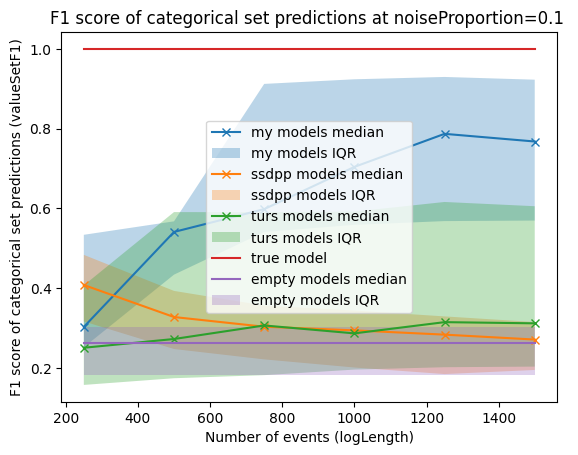

In [11]:
evaluator.plotScoreWithIqr(tableAggregated, "valueSetF1", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "turs", "true", "empty"])

In [12]:
evaluator.plotScoreWithIqr(tableAggregated, "runtime", "logLength", ["noiseProportion"],
                           ["my", "ssdpp", "turs", "true", "empty"])

# LaTeX export

In [13]:
def extractMetricForPgfplots(aggregatedTable, metricName, fileName):
    metric = aggregatedTable[metricName]
    metric.loc[:, "lowIqr"] = metric["midIqr"] - metric["lowIqr"]
    metric.loc[:, "highIqr"] = metric["highIqr"] - metric["midIqr"]
    metric = metric.rename(columns={"lowIqr": "relative lowIqr", "highIqr": "relative highIqr"})
    metric.to_csv(fileName)

In [14]:
extractMetricForPgfplots(tableAggregated, "valueSetF1", "scaling-f1-score.csv")

In [15]:
extractMetricForPgfplots(tableAggregated, "runtime", "scaling-runtime.csv")